# Seam Carving Tutorial

## 1 - Import Libraries

In [150]:
%matplotlib inline
%pprint off

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from skimage import io, color, img_as_ubyte
from scipy.ndimage.filters import sobel

import warnings

Pretty printing has been turned ON


## 2 - Define Functions

In [32]:
# Function to ...

In [184]:
# Function to find the energy of the image
def get_energy(img):
    # Convert image to greyscale
    gray = color.rgb2grey(img)
    # Convert to uint8
    with warnings.catch_warnings():
        warnings.simplefilter("ignore") # ignore warning due to type conversion
        gray = img_as_ubyte(gray)
    # return sobel image
    energy = sobel(gray)
    return energy

In [85]:
# Function to find the lowest energy seam
def get_seam(img, energy, k=0):
    # Get the number of rows and columns of the image
    rows = img.shape[0]
    cols = img.shape[1]

    # Create the seam array
    seam = np.zeros(rows, dtype='u8')

    # Matrix to compute the cumulative energy 
    cumulEnergy = np.zeros([rows,cols]) + img.size
    cumulEnergy[0,:] = np.zeros(cols, dtype='u8')
    
    # Matrix to save the path from each pixel to one of the below 3-neighboor pixels (1,0,-1)
    path = np.zeros([rows,cols])

    # Compute the cumulative energy and path matrices
    for row in range(rows-1):
        for col in range(cols):
            if col != 0:
                if cumulEnergy[row+1,col-1] > cumulEnergy[row,col] + energy[row+1,col-1]:
                    cumulEnergy[row+1,col-1] = cumulEnergy[row,col] + energy[row+1,col-1]
                    path[row+1,col-1] = 1

            if cumulEnergy[row+1,col] > cumulEnergy[row,col] + energy[row+1,col]:
                cumulEnergy[row+1,col] = cumulEnergy[row,col] + energy[row+1,col]
                path[row+1,col] = 0

            if col != cols-1:
                if cumulEnergy[row+1,col+1] > cumulEnergy[row,col] + energy[row+1,col+1]:
                    cumulEnergy[row+1,col+1] = cumulEnergy[row,col] + energy[row+1,col+1]
                    path[row+1,col+1] = -1

    if k == 0:
        # Get the column in last row with lowest cummulative energy
        seam[rows-1] = np.argmin(cumulEnergy[rows-1,:])
    else:
        # Get the column in last row with ((k+1)*10)th lowest cummulative energy
        tmp = np.argpartition(cumulEnergy[rows-1,:], k+100)
        seam[rows-1] = tmp[(k*10)%cols]
    
    # Fill up the seam array by bactracking from bottom to top
    for i in range(rows-1,0,-1):
        seam[i-1] = seam[i] + path[i, seam[i]]
    
    return seam

In [6]:
# Function to draw the seam on the image
def draw_seam(img, seam):
    imgSeam = np.copy(img)

    for i,j in enumerate(seam):
        imgSeam[i,j] = (250,0,0)
        
    return imgSeam

In [7]:
# Function to remove a seam from the image
def carve_seam(img, seam):
    # Get the number of rows and columns of the image
    rows = img.shape[0]
    cols = img.shape[1]
    
    # For every seam pixel, shift the pixels located on the same row on the right to the left by 1 position
    for r in range(rows):
        for c in range(int(seam[r]), cols - 1):
            img[r,c] = img[r,c+1]

    # Return the image without the last column
    return img[:,:cols - 1]

In [16]:
# Function to add a seam to the image
def add_seam(img, seam):
    # Get the number of rows and columns of the image
    rows = img.shape[0]
    cols = img.shape[1]
    
    seam = seam
    zero_col_mat = np.zeros((rows,1,3), dtype=np.uint8)
    imgExpanded = np.hstack((img,zero_col_mat))

    for r in range(rows):
        for c in range(cols, int(seam[r]), -1):
            imgExpanded[r,c] = img[r,c-1]

        # For smoothing, insert pixels that are the average of the left and right neighbor pixels
        for i in range(3):
            v1 = imgExpanded[r, int(seam[r])-1, i]
            v2 = imgExpanded[r, int(seam[r])+1, i]
            imgExpanded[r, int(seam[r]), i] = (int(v1)+int(v2))/2

    return imgExpanded

In [199]:
# Function to show a loading bar
def update_loading_bar(indx, totalSeams, loadingBarsCount):
    maxLoadingBars = 52
    
    if loadingBarsCount < 0:
        print('\t\t\tLoading')
        print('0%\t\t\t\t\t\t100%')
        loadingBarsCount = 0
    
    if totalSeams < maxLoadingBars:
        jumps = np.floor(maxLoadingBars / totalSeams)
        for j in range(int(jumps)):
            print('|', end='')
            loadingBarsCount = loadingBarsCount + 1
    
    else:
        jumps = np.ceil(totalSeams / maxLoadingBars)
        if i%jumps == 0:
            print('|', end='')
            loadingBarsCount = loadingBarsCount + 1
            
    if indx == totalSeams-1:
        for j in range(maxLoadingBars - loadingBarsCount):
            print('|', end='')
            
    return loadingBarsCount

## 3 - Test

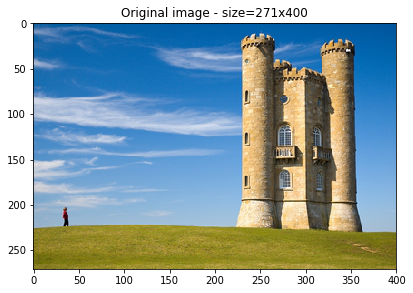

In [13]:
# Import image
img = io.imread('./test.jpg')

io.imshow(img)
plt.title('Original image - size={}x{}'.format(img.shape[0],img.shape[1]))

### 3.1 - Remove Seams

			Loading
0%						100%
||||||||||||||||||||||||||||||||||||||||||||||||||||

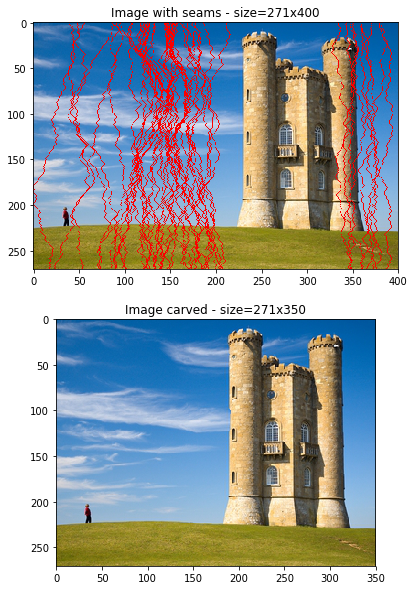

In [206]:
# Number of seams to delete
totalSeams = 50

# Image to display detected seams
imgSeams = np.copy(img)

# Image to be carved
imgCarved = np.copy(img)

loadingBarsCount = -1

# Iteratively find the seam with lowest energy and remove it
for i in range(totalSeams):
    energy = get_energy(imgCarved)
    seam = get_seam(imgCarved, energy)
    imgSeams = draw_seam(imgSeams, seam)
    imgCarved = carve_seam(imgCarved, seam)
    loadingBarsCount = update_loading_bar(i, totalSeams, loadingBarsCount)
    
# Daw the images
fig, axes= plt.subplots(nrows=2, ncols=1, figsize=(15, 10))
ax0, ax1 = axes.ravel()

ax0.imshow(imgSeams)
ax0.set_title('Image with seams - size={}x{}'.format(imgSeams.shape[0],imgSeams.shape[1]))

ax1.imshow(imgCarved)
ax1.set_title('Image carved - size={}x{}'.format(imgCarved.shape[0],imgCarved.shape[1]))

### 3.2 - Add Seams

			Loading
0%						100%
||||||||||||||||||||||||||||||||||||||||||||||||||||

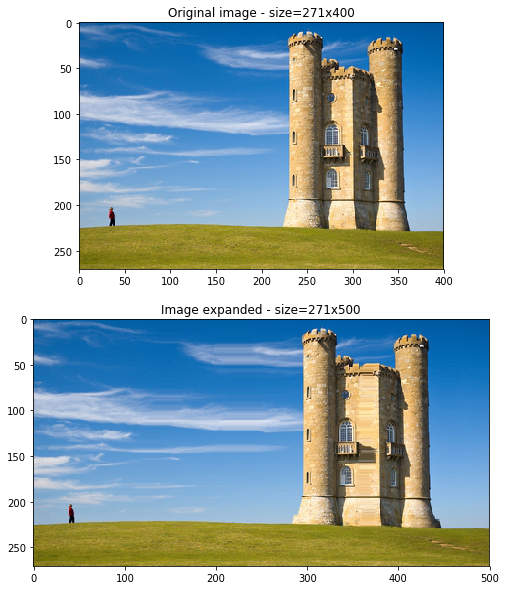

In [208]:
# Number of seams to add
totalSeams = 100

# Image to be expanded
imgExpanded = np.copy(img)

loadingBarsCount = -1

# Iteratively find the seam with lowest energy and duplicate it
for i in range(totalSeams):
    energy = get_energy(imgExpanded)
    seam = get_seam(imgExpanded, energy, i)
    imgExpanded = add_seam(imgExpanded, seam)
    loadingBarsCount = update_loading_bar(i, totalSeams, loadingBarsCount)

# Daw the images
fig, axes= plt.subplots(nrows=2, ncols=1, figsize=(15, 10))
ax0, ax1 = axes.ravel()

ax0.imshow(img)
ax0.set_title('Original image - size={}x{}'.format(img.shape[0],img.shape[1]))

ax1.imshow(imgExpanded)
ax1.set_title('Image expanded - size={}x{}'.format(imgExpanded.shape[0],imgExpanded.shape[1]))